In [16]:
from __future__ import print_function
import matplotlib.pyplot as plt
from PIL import Image
import site
import numpy as np
import os
import sys
import tarfile
from IPython.display import display
from IPython.display import Image as image2
#from PIL import Image
from scipy import ndimage
from os.path import isfile, join
import h5py

from sklearn.linear_model import LogisticRegression
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle


# the usual beautification line
%matplotlib inline


In [17]:
###this first part is more or lest unchanged from the not_mnist exerise###

url = 'http://ufldl.stanford.edu/housenumbers/'
last_percent_reported = None

def download_progress_hook(count, blockSize, totalSize):
  """A hook to report the progress of a download. This is mostly intended for users with
  slow internet connections. Reports every 1% change in download progress.
  """
  global last_percent_reported
  percent = int(count * blockSize * 100 / totalSize)

  if last_percent_reported != percent:
    if percent % 5 == 0:
      sys.stdout.write("%s%%" % percent)
      sys.stdout.flush()
    else:
      sys.stdout.write(".")
      sys.stdout.flush()
      
    last_percent_reported = percent
        
def maybe_download(filename, expected_bytes, force=False):
  """Download a file if not present, and make sure it's the right size."""
  if force or not os.path.exists(filename):
    print('Attempting to download:', filename) 
    filename, _ = urlretrieve(url + filename, filename, reporthook=download_progress_hook)
    print('\nDownload Complete!')
  statinfo = os.stat(filename)
  if statinfo.st_size == expected_bytes:
    print('Found and verified', filename)
  else:
    #print(statinfo.st_size)
    raise Exception(
      'Failed to verify ' + filename + '. Can you get to it with a browser?')
  return filename

train_filename = maybe_download('train.tar.gz',404141560)
test_filename = maybe_download('test.tar.gz',276555967)


Found and verified train.tar.gz
Found and verified test.tar.gz


In [18]:
###triggering the tar gz file extraction and presenting a sample of files in the unzipped folder###

num_classes = 10
np.random.seed(133)

def maybe_extract(filename, force=False):
  root = os.path.splitext(os.path.splitext(filename)[0])[0]  # remove .tar.gz
  if os.path.isdir(root) and not force:
    # You may override by setting force=True.
    print('%s already present - Skipping extraction of %s.' % (root, filename))
  else:
    print('Extracting data for %s. This may take a while. Please wait.' % root)
    tar = tarfile.open(filename)
    sys.stdout.flush()
    tar.extractall()
    tar.close()
  
train_folders = maybe_extract(train_filename)
test_folders = maybe_extract(test_filename)

print("folder test sample: %s" % os.listdir('test')[:5])
print("folder train sample: %s " % os.listdir('train')[:5])

train already present - Skipping extraction of train.tar.gz.
test already present - Skipping extraction of test.tar.gz.
folder test sample: ['1.png', '10.png', '100.png', '1000.png', '10000.png']
folder train sample: ['24634.png', '1.png', '10.png', '100.png', '1000.png'] 


In [19]:
testfiles = [f for f in os.listdir('test') if isfile(join('test', f))]
trainfiles = [f for f in os.listdir('train') if isfile(join('train', f))]

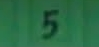

In [20]:
display(image2(filename="test/1.png"))
display(image2(filename="train/24634.png"))

In [21]:
#print (testfiles)[:5]
#dim_array1 = []
#def get_dimensions(archives):
# for i in archives:
 #   with Image.open("train/"+i) as im:
  #      width, height = im.size
   #     dim_array1.append((width,height))
#get_dimensions(testfiles)

#print(dim_array1[:5])
####IOError: cannot identify image file 'train/digitStruct.mat'

In [22]:
   # file=h5py.File("train/digitStruct.mat")
    
    #file.keys()
   # file['digitStruct'].keys()
    #file['digitStruct']['name'][1][0]
    #file['digitStruct']['name'].shape[0]
    #docname = file[file['digitStruct']['name'][1][0]].value.tostring()
    #for i in range(0,5):
     #   print(file[file['digitStruct']['name'][0][0]][i])
    #file['digitStruct']['bbox'].shape[0]
  #  obj = file['digitStruct']['bbox'][0]
   # print(obj)

In [29]:
def get_attr(f,i,attr):
    attr = f[f['digitStruct']['bbox'][i][0]][attr].value.squeeze()
    try:
        return list(np.array([f[x].value for x in attr]).squeeze())
    except:
        return list(attr.reshape(-1))
    #will complain about "iteration over 1D array" without the above 

def format_name(file,i):
    name = file[file["digitStruct"]["name"][i][0]].value.tostring()
    name = name.replace('\x00','')
    return name 
    

def get_data(path):
    filename = h5py.File(path)
    picarray = filename['digitStruct']['name'].shape[0]
    images = []
    labels = []
    heights = []
    widths = []
    tops = []
    lefts = []
    
    print(path)
    for picno in range(0,picarray):
        #images.append(filename[filename["digitStruct"]["name"][picno][0]].value.tostring())
        #print(images)
        images.append(format_name(filename, picno))
        #print(images)
        labels.append(get_attr(filename, picno, 'label'))
        heights.append(get_attr(filename, picno, 'height'))
        widths.append(get_attr(filename, picno, 'width'))
        lefts.append(get_attr(filename, picno, 'left'))
        tops.append(get_attr(filename, picno, 'top'))
        
        if (picno % 10000 == 0):
            print(picno)
        if (picno % 5000 == 0):
            print('another 5k')
    
    return np.array(images),np.array(labels),np.array(heights),np.array(widths),np.array(lefts),np.array(tops)



In [31]:
def create_dataset(): # Get Metadata for each dataset
    train_dataset = dict()
    test_dataset = dict()
    train_dataset["images"],train_dataset["labels"],train_dataset["heights"],train_dataset["widths"],\
    train_dataset["lefts"],train_dataset["tops"] = get_data("train/digitStruct.mat")
    test_dataset["images"],test_dataset["labels"],test_dataset["heights"],test_dataset["widths"],\
    test_dataset["lefts"],test_dataset["tops"] = get_data("test/digitStruct.mat")
    return train_dataset,test_dataset

In [32]:
pickle_file = 'SVHN.pickle'

dataset={
    'train_dataset':train_dataset,
    'test_dataset':test_dataset
}

with open(pickle_file, 'wb') as picklefile:
    pickle.dump(dataset, picklefile, pickle.HIGHEST_PROTOCOL)
picklefile.close()



In [33]:
train_dataset,test_dataset = create_dataset()

train/digitStruct.mat
0
another 5k
another 5k
10000
another 5k
another 5k
20000
another 5k
another 5k
30000
another 5k
test/digitStruct.mat
0
another 5k
another 5k
10000
another 5k


In [62]:
with open(pickle_file, 'rb') as f:
    save = pickle.load(f)
    train_dataset = save['train_dataset']
    test_dataset = save['test_dataset']
    del save

In [63]:
statinfo = os.stat(pickle_file)
print('Compressed pickle size:', statinfo.st_size)

Compressed pickle size: 12664823


In [64]:
obj = train_dataset['heights'][1]
print(obj)

def boundingbox(file,pxlabel):
    details= []
    for i in file[pxlabel]:
        #print(i)
        for y in i:
            details.append(y)
    return details

[32.0, 32.0]


In [65]:
list_height_train=boundingbox(train_dataset,'heights')
list_height_test=boundingbox(test_dataset,'heights')
list_width_train=boundingbox(train_dataset,'widths')
list_width_test=boundingbox(test_dataset,'widths')

In [66]:
print(list_height_train[:5])
print(list_height_test[:5])
print(list_width_train[:5])
print(list_width_test[:5])

[219.0, 219.0, 32.0, 32.0, 15.0]
[30.0, 23.0, 23.0, 23.0, 16.0]
[81.0, 96.0, 23.0, 26.0, 8.0]
[19.0, 14.0, 8.0, 12.0, 11.0]


In [67]:
train_dataset["images"].shape[0]
train_dataset["images"][-1]
train_dataset["labels"][50]
len(train_dataset["labels"][82])

2

In [68]:
del_list = []

def create_dataset(path,data):
    #number of images
    length=data['images'].shape[0]
    #array format considering number of images, image dimensions and r g b values
    dataset = np.ndarray([length,32,32,3], dtype='float32')
    #creating an array of ones where the digit labels are to be stored
    labels = np.ones([length,6], dtype=int) *10
    
    #for each image...
    for i in np.arange(length):
        #retrieve file name, file location and load image
        image_name = data['images'][i]
        path_image = os.path.join(path,image_name)
        image = Image.open(path_image)
        
        #number of digits per image
        num_digit = len(data['labels'][i])
        #digit number of each given image label
        labels[i,0] = num_digit
        
        #setting arrays for each digit and positional element of the bounding box
        top = np.ndarray([num_digit], dtype='float32')
        left = np.ndarray([num_digit], dtype='float32')
        height = np.ndarray([num_digit], dtype='float32')
        width = np.ndarray([num_digit], dtype='float32')
        
        #for each digit
        for j in np.arange(num_digit):
            if j < 4:
                labels[i,j+1] = data['labels'][i][j]
                if data['labels'][i][j] == 10: 
                    labels[i,j+1] = 0
            else: 
                print('Image',i,' has to be deleted.') # Delete image with more than 4 digits
                del_list.append(i)
                                
            #get bounding box per digit    
            top[j] = data['tops'][i][j]
            left[j] = data['lefts'][i][j]
            height[j] = data['heights'][i][j]
            width[j] = data['widths'][i][j]
        
        #finding extreme values from all digit bounding boxes to define the overall image bounding box
        image_top = np.amin(top)
        image_left = np.amin(left)
        image_height = np.amax(top) + height[np.argmax(top)] - image_top
        image_width = np.amax(left) + width[np.argmax(left)] - image_left
        
        image_top = np.floor(image_top - 0.1 * image_height)
        image_left = np.floor(image_left - 0.1 * image_width)
        image_bottom = np.amin([np.ceil(image_top + 1.2 * image_height), image.size[1]])
        image_right = np.amin([np.ceil(image_left + 1.2 * image_width), image.size[0]])

        #resizing/cropping images according to the bouding box information.
        image = image.crop((image_left, image_top, image_right, image_bottom)).resize([32,32], Image.ANTIALIAS)
        dataset[i,:,:,:] = image

    return dataset, labels

In [75]:
train_dataset,train_labels =create_dataset("train",train_dataset)

Image 4110  has to be deleted.
Image 6738  has to be deleted.
Image 15957  has to be deleted.
Image 18262  has to be deleted.
Image 18943  has to be deleted.
Image 24040  has to be deleted.
Image 24551  has to be deleted.
Image 26698  has to be deleted.
Image 29929  has to be deleted.
Image 29929  has to be deleted.
Image 33228  has to be deleted.


In [72]:
def clean_dataset(dataset):
    print(del_list)
    print('before: ',dataset.shape)
    for i in range(len(del_list)):
        dataset = np.delete(dataset, del_list[i], axis=0)       
    print('after: ',dataset.shape)

In [74]:
clean_dataset(train_dataset)
clean_dataset(train_labels)

[2998, 7313]


AttributeError: 'dict' object has no attribute 'shape'

In [69]:


test_dataset,test_labels =create_dataset("test",test_dataset)



Image 2998  has to be deleted.
Image 7313  has to be deleted.


In [70]:
clean_dataset(test_dataset)
clean_dataset(test_labels)

[2998, 7313]
before:  (13068, 32, 32, 3)
after:  (13066, 32, 32, 3)
[2998, 7313]
before:  (13068, 6)
after:  (13066, 6)


In [76]:
print('Train: ',train_dataset.shape, train_labels.shape)
print('Test: ',test_dataset.shape, test_labels.shape)

###why are the deleted images back in ???####

Train:  (33402, 32, 32, 3) (33402, 6)
Test:  (13068, 32, 32, 3) (13068, 6)


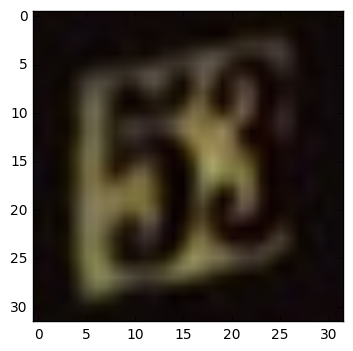

In [77]:
img=train_dataset[100,:,:,:]
plt.imshow(img)

In [78]:
np.random.seed(7)

def shuffle(data, labels):
    permut = np.random.permutation(labels.shape[0])
    shuffled_dataset = data[permut,:,:,:]
    shuffled_labels = labels[permut]
    print('done deal')
    return shuffled_dataset, shuffled_labels



In [79]:
train_dataset, train_labels = shuffle(train_dataset, train_labels)


done deal


In [80]:
def greyimg(data): 
    coeff_red = 0.3
    coeff_green = 0.6
    coeff_blue = 0.1
    data = data[:,:,:,0]*coeff_red+data[:,:,:,1]*coeff_green+data[:,:,:,2]*coeff_blue
    return data

train_dataset = greyimg(train_dataset)
test_dataset = greyimg(test_dataset)

In [86]:
def meanset(dataset):
    for i in range(0,dataset.shape[0]):
        dataset[i,:,:]=(dataset[i,:,:]-dataset[i,:,:].mean())/dataset[i,:,:].std()
    return dataset

train_dataset=meanset(train_dataset)
test_dataset=meanset(test_dataset)

In [87]:
mlreadyfile = h5py.File('SVHN.hdf5')
mlreadyfile['train_dataset']=train_dataset
mlreadyfile['train_labels']=train_labels
mlreadyfile['test_dataset']=test_dataset
mlreadyfile['test_labels']=test_labels
mlreadyfile.close()
print('done deal')

done deal


In [88]:
statinfo = os.stat('SVHN.hdf5')
print('size:', statinfo.st_size)


size: 192575872
